<a href="https://colab.research.google.com/github/joshualewin6/Colab-Notebook/blob/main/JoshLewiU3proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Total Points per Team per Game in the NFL

##Introduction
I'm an avid follower of the NFL. (No thanks to my Dolphins, by now I just care about fantasy football.) I have noticed this year that the quarterbacks have been lacking. Mahomes keeps throwing picks, Rodgers *really* needs to retire, and some of the best performing quarterbacks are Sam Darnold, Baker Mayfield, and Kirk Cousins. On the other hand, some teams have racked up the score ridiculous amount, with the Ravens, Saints, and Commanders having monster offensive seasons so far. It's made me curious how the point distribution has stacked up so far this season. In this project, I'll be using a model to predict the the probability of an NFL team getting certain scores in a game.

Let's get started by importing our libraries.

In [36]:
!pip install "preliz[full,notebook]"

In [37]:
import preliz as pz

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import arviz as az
import pymc as pm
import random
import math

##Plan for the Prior

For the prior, I plan to select the mean from a Normal distribution with mean 22.5 (roughly the nfl league average ppg for modern football), and have about 90% of means fall between 20.5 and 24.5, just based on what I've seen in previous seasons. From there, I'll give it a standard deviation selecting from a HalfNormal distribution with standard deviation of 12, since football scores vary quite a bit.

##Plan for the Likelihood
The likelihood will be a Gamma distribution, since it needs to incorporate a mean and standard deviation. The posterior will incorporate the observed data form this season. (I got assembled the data on a spreadsheet, thank you for the help with that, Colin.) (Also, this is data through week 6, it works for our purposes, but it's not a full season.)

Why a Gamma? Well, as I mentioned, it needs mean and stdev, but it's also naturally skewed right, perfect for nfl scores that can sometimes get very high. (I mean, who doesn't love a good 41-38 game.) On top of that, it supports 0 to infinity, whereas with, for instance, a StudentT distribution would give me negative scores, which is impossible in football. Therefore, the Gamma is a great choice for the distribution, and it's what I'll use.

(array([ 8., 18., 35., 37., 32., 20., 19.,  8.,  3.,  4.]),
 array([ 3. ,  7.8, 12.6, 17.4, 22.2, 27. , 31.8, 36.6, 41.4, 46.2, 51. ]),
 <BarContainer object of 10 artists>)

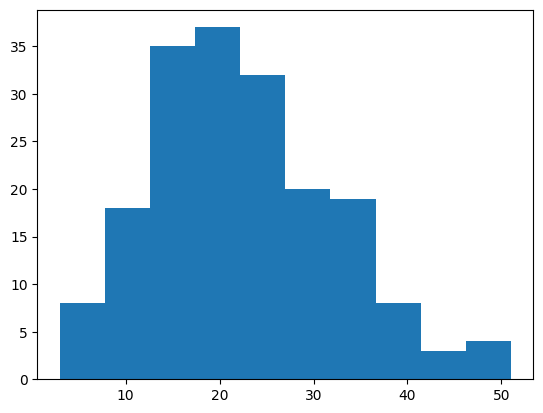

In [39]:
data_nfl=[27,34,10,34,24,10,17,26,27,22,20,47,6,26,37,32,10,41,23,3,19,6,16,16,19,13,26,23,20,17,21,21,24,13,17,15,25,21,22,27,34,12,20,24,7,14,47,33,15,14,26,35,24,24,29,24,27,20,10,9,30,33,42,12,20,29,18,28,17,16,33,20,29,10,17,10,28,20,20,19,31,10,26,26,44,13,20,10,13,18,25,17,23,24,18,22,3,20,22,21,28,16,36,24,7,15,10,3,26,30,10,38,20,42,24,10,34,18,31,20,24,16,17,10,13,16,29,31,30,36,17,23,10,36,13,34,15,10,34,37,20,23,41,38,18,34,24,23,29,20,24,19,20,17,13,26,36,24,16,35,51,27,23,30,13,34,20,17,41,21,16,20,23,16,32,13,38,20,47,9,17,7,23,20]
plt.hist(data_nfl)

## Putting It Together
Now we can build a model for predicting the score distribution that incorporates our priors and check to see if it somewhat makes sense with the observed data.

In [40]:
with pm.Model() as model_nfl:
    #90% of values between 20.5 and 24.5 for the mean)
    μ = pm.Normal('μ', mu=22.5, sigma=1.22)
    #For the standard devation, I don't know what that should really look like, so a simple HalfNormal should suffice, sigma=12 makes the mean about 9.5
    σ = pm.HalfNormal('σ', sigma=12)
    #Normal distribution because we don't have a nu with which to create a StudentT
    Y = pm.Gamma('Y', mu = μ, sigma = σ, observed=data_nfl)
    idata_nfl = pm.sample()

Output()

Output()

array([<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'σ'}>],
      dtype=object)

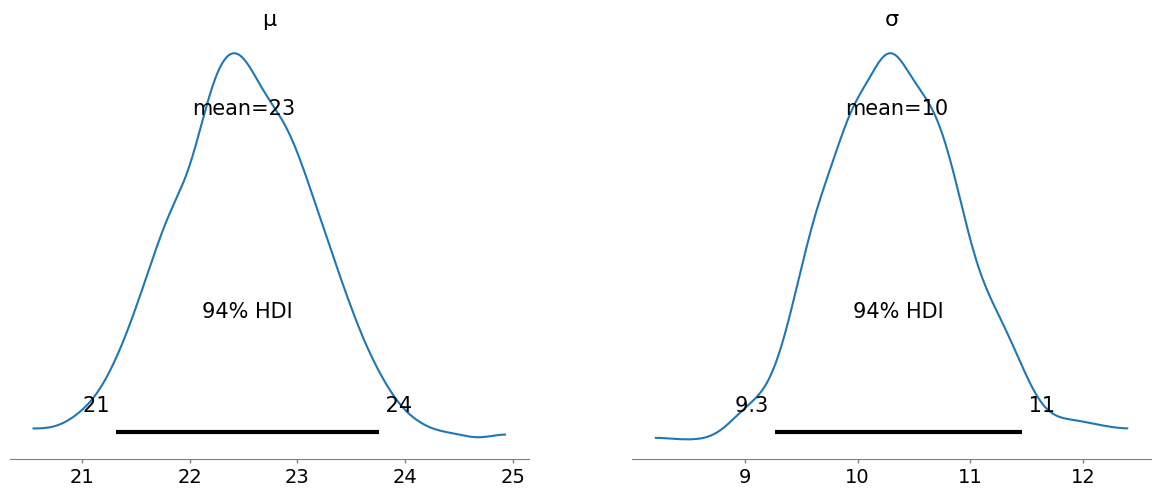

In [41]:
#Let's see what this looks like for our two prior distributions by plotting them
az.plot_posterior(idata_nfl)

In [42]:
pm.sample_posterior_predictive(idata_nfl, model=model_nfl, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='Y'>

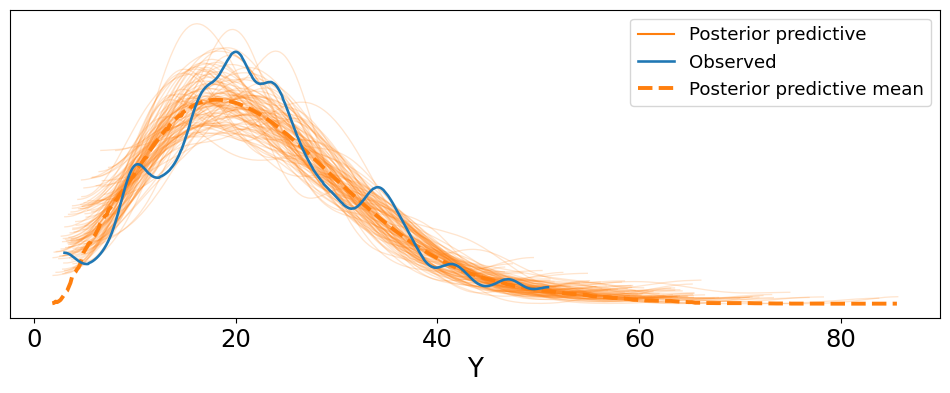

In [43]:
#Still using the notes pretty directly, so far our prior looks reasonable, let's compare to the observed distribution
az.plot_ppc(idata_nfl, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

###Score Generator
This can get wildly inaccurate (generating 15-8 once and 11-9 another time are funny examples), but it isn't terrible the vast majority of the time, and gets resonable scores like 23-13, 33-31, 20-6, 21-20, etc. Thought I'd add it just for fun.

In [44]:
stacked_scores = az.extract(idata_nfl, group="posterior_predictive")
stacked_scores

<xarray.Dataset> Size: 3MB
Dimensions:  (Y_dim_2: 184, sample: 2000)
Coordinates:
  * Y_dim_2  (Y_dim_2) int64 1kB 0 1 2 3 4 5 6 7 ... 177 178 179 180 181 182 183
  * sample   (sample) object 16kB MultiIndex
  * chain    (sample) int64 16kB 0 0 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1 1 1
  * draw     (sample) int64 16kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables:
    Y        (Y_dim_2, sample) float64 3MB 21.2 24.97 16.34 ... 12.69 17.14
Attributes:
    created_at:                 2024-10-17T04:21:13.994956+00:00
    arviz_version:              0.19.0
    inference_library:          pymc
    inference_library_version:  5.16.2

In [45]:
print(math.floor(stacked_scores.sel(sample=0).sel(draw=random.randrange(0,1000)).Y.to_series().values[random.randrange(0,184)])," ",math.floor(stacked_scores.sel(sample=0).sel(draw=random.randrange(0,1000)).Y.to_series().values[random.randrange(0,184)]))

21   20


##Conclusion
This is actually a decent estimation, as good as we'll get with the models we work with as of now. Noticeably, it is not perfect, the observed data is incredibly "lumpy," so the smooth average distribution isn't perfectly reflective of what the data should look like. The distribution is still helpful, though.

It shows pretty well when compared with observed data how much the scores differ from a reasonably predicted score distribution, giving some interesting scores for the most significant modes (3,20,21,24,34) and dips (5,11,12,32,39). This tracks, since points are gained in football typically in chunks of 3 or 7, and very rarely also 2,6, and 8. Thus, scores that are linear combinations of $3a+7b|a,b∈ℕ$ where both a+b and |a-b| are smaller are the most likely scores in games.

A future model that predicts this more accurately might use a Poisson distribution for the total possesions in a game for a team, and then use further priors for predicting a touchdown (with pat, 2pt, or neither), field goal, safety, or punt/turnover. Maybe it could even simulate overtime to avoid ties showing up too much in the predictions. That way we could get a prior with discrete scores and "lumpiness" that actually represents football scores.